In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from lib.component.json_handle import load_dicts_from_jsonl, save_dicts_to_jsonl
from lib.component.model_builder import ModelBuilder, ModelBuilderV2
from lib.component.embedding import build_embedding

In [4]:
import langsmith

In [13]:
from langsmith.wrappers import wrap_openai
from langsmith import traceable

In [14]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [5]:
llm = ModelBuilder.createVseGptModel("neversleep/llama-3-lumimaid-8b-large", 0)

In [15]:
@traceable
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [16]:
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")

In [17]:
graph = graph_builder.compile()

In [18]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [19]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Assistant: I'm just a language model, I don't have feelings or emotions like humans do, but I'm functioning properly and ready to help with any questions or tasks you have! How about you? How's your day going?<|eot_id|>
Goodbye!


In [5]:
from dotenv import load_dotenv
load_dotenv()

True

In [6]:
from typing_extensions import TypedDict
from typing import Dict, List


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[Dict]
    filtered_documets: List[Dict]
    is_fuse: bool
    count_regenerations: int

In [7]:
from lib import FAISSBuilder

In [6]:
# from langchain.prompts import PromptTemplate
# from langchain_core.output_parsers import JsonOutputParser

# from lib.component.model_builder import ModelBuilderV2
# prompt = PromptTemplate(
#     template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
#     Here is the retrieved document: \n\n {document} \n\n
#     Here is the user question: {question} \n
#     If the document contains keywords related to the user question, grade it as relevant. \n
#     It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
#     Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
#     Provide the binary score as a JSON with a single key 'score' and no premable or explanation.""",
#     input_variables=["question", "document"],
# )
# with ModelBuilderV2("meta-llama/llama-3-8b-instruct") as llm:
#     retrieval_grader = prompt | llm | JsonOutputParser()
#     question = "Я оформляю сделку дарения недвижимости – мне дарит квартиру человек, который не является моим родственником. Нужно ли будет платить налог?"
#     with FAISSBuilder() as retriever:
#         docs = retriever.get_relevant_documents(question)
#         doc_txt = docs[1].page_content
#         print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

/home/dennis/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/dennis/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
2024-05-21 23:15:58.119059: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-21 23:15:58.364119: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in perfo

{'score': 'yes'}


In [65]:
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain.retrievers.multi_query import MultiQueryRetriever

from lib.component.model_builder import ModelBuilderV2
prompt = PromptTemplate(
    template="""You are a grader assessing relevance of a retrieved documents to a user question. \n 
    Here is the first retrieved document: \n\n {document_1} \n\n
    Here is the second retrieved document: \n\n {document_2} \n\n
    Here is the third retrieved document: \n\n {document_3} \n\n
    Here is the user question: {question} \n
    If the document contains keywords related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    For each! document give a score from 0 to 1, score to indicate whether the document is relevant to the question. \n
    Provide the scores as a JSON list that contains an objects with single key 'score' and no premable or explanation.""",
    input_variables=["question", "document_1", "document_2", "document_3"],
)
with ModelBuilderV2("cohere/command-r") as llm:
    retrieval_grader_3_docs = prompt | llm | JsonOutputParser()
    question = "Я оформляю сделку дарения недвижимости – мне дарит квартиру человек, который не является моим родственником. Нужно ли будет платить налог?"
    with FAISSBuilder() as faiss_retriever:
        with ModelBuilderV2("openchat/openchat-7b") as mq_llm:
            retriever = MultiQueryRetriever.from_llm(retriever=faiss_retriever, llm=llm)
            docs = retriever.get_relevant_documents(question)
            doc_txt = docs[1].page_content
            print(docs)
            print(retrieval_grader_3_docs.invoke({"question": question, "document_1": docs[0], "document_2": docs[1], "document_3": docs[2]}))

/home/dennis/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches: 100%|██████████| 1/1 [00:00<00:00, 40.15it/s]


[Document(page_content='html xmlnshttpwww.w3.org1999xhtml head meta namecprevision content1  meta nameextendedpropertiesAppVersion content15.0000  meta namemetaparagraphcount content791  meta namemetawordcount content59156  meta nameextendedpropertiesApplication contentMicrosoft Office Word  meta namemetalastauthor contentБерезин Александр Александрович  meta namedccreator contentБерезин Александр Александрович  meta nameextendedpropertiesCompany content  meta namexmpTPgNPages content95  meta nameresourceName contentbxd0x9dxd0x9a.xd0x9axd0xbexd0xbcxd0xbcxd0xb5xd0xbdxd1x82xd0xb0xd1x80xd0xb8xd0xb9.xd0x9bxd0xb5xd1x80xd0xbcxd0xbexd0xbdxd1x82xd0xbexd0xb2.xd1x87xd0xb0xd1x81xd1x82xd1x8c 02.xd0xb3xd0xbb.21.2019.docx  meta namedctermscreated content20200426T070800Z  meta namemetalinecount content2809  meta namedctermsmodified content20200426T071200Z  meta namemetacharactercount content337192  meta nameextendedpropertiesTemplate contentNormal  meta namemetacharactercountwithspaces content395557 

In [64]:
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain.retrievers.multi_query import MultiQueryRetriever

from lib.component.model_builder import ModelBuilderV2
prompt = PromptTemplate(
    template="""You are a grader assessing relevance of a retrieved documents to a user question. \n 
    Here is the retrieved documents: \n\n {documents} \n\n
    Here is the user question: {question} \n
    If the document contains keywords related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    For each! document give a score from 0 to 1, score to indicate whether the document is relevant to the question. \n
    Provide the scores as a JSON list that contains an objects with single key 'score' and no premable or explanation.""",
    input_variables=["question", "documents"],
)
with ModelBuilderV2("cohere/command-r") as llm:
    retrieval_grader_docs = prompt | llm | JsonOutputParser()
    question = "Я оформляю сделку дарения недвижимости – мне дарит квартиру человек, который не является моим родственником. Нужно ли будет платить налог?"
    with FAISSBuilder() as faiss_retriever:
        with ModelBuilderV2("openchat/openchat-7b") as mq_llm:
            retriever = MultiQueryRetriever.from_llm(retriever=faiss_retriever, llm=llm)
            docs = retriever.get_relevant_documents(question)
            doc_txt = docs[1].page_content
            print(docs)
            print(retrieval_grader_docs.invoke({"question": question, "documents": docs}))

/home/dennis/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches: 100%|██████████| 1/1 [00:00<00:00, 101.55it/s]


[Document(page_content='html xmlnshttpwww.w3.org1999xhtml head meta namecprevision content1  meta nameextendedpropertiesAppVersion content15.0000  meta namemetaparagraphcount content791  meta namemetawordcount content59156  meta nameextendedpropertiesApplication contentMicrosoft Office Word  meta namemetalastauthor contentБерезин Александр Александрович  meta namedccreator contentБерезин Александр Александрович  meta nameextendedpropertiesCompany content  meta namexmpTPgNPages content95  meta nameresourceName contentbxd0x9dxd0x9a.xd0x9axd0xbexd0xbcxd0xbcxd0xb5xd0xbdxd1x82xd0xb0xd1x80xd0xb8xd0xb9.xd0x9bxd0xb5xd1x80xd0xbcxd0xbexd0xbdxd1x82xd0xbexd0xb2.xd1x87xd0xb0xd1x81xd1x82xd1x8c 02.xd0xb3xd0xbb.21.2019.docx  meta namedctermscreated content20200426T070800Z  meta namemetalinecount content2809  meta namedctermsmodified content20200426T071200Z  meta namemetacharactercount content337192  meta nameextendedpropertiesTemplate contentNormal  meta namemetacharactercountwithspaces content395557 

In [50]:
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain.retrievers.multi_query import MultiQueryRetriever

from lib.component.model_builder import ModelBuilderV2
prompt = PromptTemplate(
    template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n
    If the document contains keywords related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    For document give a score from 0 to 1, score to indicate whether the document is relevant to the question. \n
    Provide the score as a JSON with a single key 'score' and no premable or explanation.""",
    input_variables=["question", "document"],
)
with ModelBuilderV2("openchat/openchat-7b") as llm:
    retrieval_grader = prompt | llm | JsonOutputParser()
    # question = "Я оформляю сделку дарения недвижимости – мне дарит квартиру человек, который не является моим родственником. Нужно ли будет платить налог?"
    # with FAISSBuilder() as faiss_retriever:
    #     with ModelBuilderV2("openchat/openchat-7b") as mq_llm:
    #         retriever = MultiQueryRetriever.from_llm(retriever=faiss_retriever, llm=llm)
    #         docs = retriever.get_relevant_documents(question)
    #         doc_txt = docs[1].page_content
    #         print(docs)
    #         print(retrieval_grader.invoke({"question": question, "documents": docs}))

In [51]:
### Question Re-writer
from langchain_core.output_parsers import StrOutputParser
# LLM
with ModelBuilderV2("openchat/openchat-7b") as llm:
# Prompt
    re_write_prompt = PromptTemplate(
        template="""You a question re-writer that converts an input question to a better version that is optimized \n 
        for vectorstore retrieval. Look at the initial and formulate an improved question. Write it in Russian. \n
        Here is the initial question: \n\n {question}. Improved question with no preamble: \n """,
        input_variables=["generation", "question"],
    )

    question_rewriter = re_write_prompt | llm | StrOutputParser()
    question_rewriter.invoke({"question": question})

In [8]:
question_rewriter.invoke({"question": question})

'Here is the rewritten question in Russian:\n\nНужно ли платить налог при дарении недвижимости не родственником?\n\nTranslation: Do I need to pay tax when gifting real estate to a non-relative?\n\nThis rewritten question is optimized for vectorstore retrieval as it:\n\n* Removes unnecessary context and gets straight to the point\n* Uses specific and relevant keywords (дарение, недвижимость, налог)\n* Is concise and easy to understand\n* Does not contain ambiguity or ambiguity-prone words (like "оформляю сделку")\n\nThis rewritten question is more likely to retrieve relevant results from a vectorstore, as it is more specific and focused on the core query.'

In [79]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate


# Prompt
# prompt = hub.pull("rlm/rag-prompt")
template = """Tasks: 1) Answer the following question in Russian using only the provided context.
    2) Print all - unique sources from context that were used to generate the answer.

    Context: {context}

    Question: {question}

    Answer:

    Использованные источники:
    
    """
prompt = ChatPromptTemplate.from_template(template)
with ModelBuilderV2("cohere/command-r") as llm:
# Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

#     # Run
#     generation = rag_chain.invoke({"context": docs, "question": question})
# print(generation)

In [80]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    with FAISSBuilder() as faiss_retriever:
        with ModelBuilderV2("openchat/openchat-7b") as mq_llm:
            retriever = MultiQueryRetriever.from_llm(retriever=faiss_retriever, llm=mq_llm)
            documents = retriever.get_relevant_documents(question)
            return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    count_docs = len(documents)
    for ind_d in range(0, count_docs, 3):
        d_1 = documents[ind_d] if ind_d < count_docs else None
        d_2 = documents[ind_d + 1] if ind_d + 1 < count_docs else None
        d_3 = documents[ind_d + 2] if ind_d + 2 < count_docs else None
        scores = retrieval_grader_3_docs.invoke(
            {"question": question, "document_1": d_1, "document_2": d_2, "document_3": d_3}
        )
        for j in range(len(scores)):
            grade = scores[j]["score"]
            if grade > 0.7:
                print(f"---GRADE: DOCUMENT RELEVANT--- GRADE: {grade}")
                filtered_docs.append(documents[ind_d + j])
            else:
                print("---GRADE: DOCUMENT NOT RELEVANT---")
    is_fuse = len(filtered_docs) / len(documents) <= 0.5
        
    return {"documents": filtered_docs, "question": question}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


### Edges


def decide_to_regenerate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    # web_search = state["web_search"]
    filtered_documents = state["documents"]

    # if web_search == "Yes":
    #     # All documents have been filtered check_relevance
    #     # We will re-generate a new query
    #     print(
    #         "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
    #     )
    #     return "transform_query"
    # else:
        # We have relevant documents, so generate answer
    # is_fuse = state['is_fuse']
    # count_regenerations = state['count_regenerations']
    # if is_fuse and count_regenerations < 4:
    #     state['count_regenerations'] = count_regenerations + 1
    #     print("---DECISION: REGENERATE---")
    #     return "regenerate"
    return "transform_query"

In [81]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_regenerate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

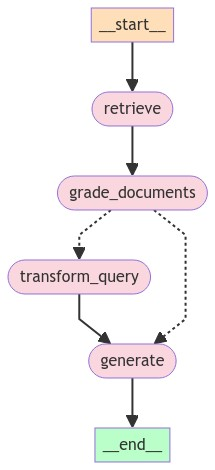

In [13]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [83]:
app.invoke(inputs)

---RETRIEVE---


/home/dennis/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches: 100%|██████████| 1/1 [00:00<00:00, 81.21it/s]


---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT--- GRADE: 1
---GRADE: DOCUMENT RELEVANT--- GRADE: 1
---GRADE: DOCUMENT RELEVANT--- GRADE: 1
---ASSESS GRADED DOCUMENTS---
---TRANSFORM QUERY---
---GENERATE---


{'question': 'Если я получаю подарок в виде квартиры от человека, который не является моим родственником, нужно ли платить налог при оформлении сделки дарения недвижимости?',
 'generation': 'Да, согласно письму Минфина России от 21.11.2013 N 03040550286, доходы, полученные в порядке дарения от человека, который не является членом вашей семьи или близким родственником, не подпадают под освобождение от налогообложения, о котором говорится в пункте 18 статьи 217 НК РФ. Поэтому, стоимость полученной в дар квартиры будет подлежать налогообложению налогом на доходы физических лиц. Сумма налога будет рассчитана исходя из рыночной стоимости квартиры на момент дарения.\n\n*Письмо Минфина России от 21.11.2013 N 03040550286*',
 'documents': [Document(page_content='письмо от 01.07.2010 N 20144069188.p pВ письме от 10.06.2010 N 03040510323 Минфин России пояснил, что перечень доходов, не подлежащих налогообложению налогом на доходы физических лиц, установленный статьей 217 НК РФ, является исчерпываю

In [82]:
from pprint import pprint

# Run
inputs = {"question": "Я оформляю сделку дарения недвижимости – мне дарит квартиру человек, который не является моим родственником. Нужно ли будет платить налог?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---


/home/dennis/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches: 100%|██████████| 1/1 [00:00<00:00, 74.50it/s]


"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT--- GRADE: 1
---GRADE: DOCUMENT RELEVANT--- GRADE: 1
---GRADE: DOCUMENT RELEVANT--- GRADE: 1
---ASSESS GRADED DOCUMENTS---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('Да, согласно письму Минфина России от 21.11.2013 N 03040550286, доходы, '
 'полученные в порядке дарения от человека, который не является членом вашей '
 'семьи или близким родственником, не подлежат освобождению от налогообложения '
 'в соответствии с пунктом 18 статьи 217 НК РФ. Поэтому, если вы оформили '
 'дарение квартиры от такого лица, то стоимость полученного вами имущества '
 'подлежит налогообложению по ставкам налога на доходы физических лиц.\n'
 '\n'
 '* письмо Минфина России от 21.11.2013 N 03040550286\n'
 '* письмо от 07.10.2010 N 03040510606')


In [77]:
from pprint import pprint

# Run
inputs = {"question": "Я пенсионерка, на пенсии с 2009 года. В этом году приобрела квартиру. Могу ли я воспользоваться налоговым вычетом?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---


/home/dennis/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches: 100%|██████████| 1/1 [00:00<00:00, 102.66it/s]


"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT--- GRADE: 1
---GRADE: DOCUMENT RELEVANT--- GRADE: 0.9999999999999999
---GRADE: DOCUMENT RELEVANT--- GRADE: 0.9999999999999999
---GRADE: DOCUMENT RELEVANT--- GRADE: 0.9999999999999999
---ASSESS GRADED DOCUMENTS---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('Да, вы можете воспользоваться налоговым вычетом, так как с 1 января 2014 '
 'года все пенсионеры имеют право на получение имущественного налогового '
 'вычета, независимо от наличия у них доходов, облагаемых по налоговой ставке '
 'в 13\xa0%. Однако, обратите внимание, что вычеты предоставляются только один '
 'раз, поэтому, если вы ранее уже пользовались таким вычетом, то сейчас у вас '
 'не выйдет это сделать повторно.')


chats

In [5]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai.chat_models import ChatOpenAI

with ModelBuilderV2("openchat/openchat-7b") as model: 
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You're an assistant who's good at {ability}. Respond in 20 words or fewer",
            ),
            MessagesPlaceholder(variable_name="history"),
            ("human", "{input}"),
        ]
    )
    runnable = prompt | model

In [11]:
prompt.invoke(input={"input": "stuff", "ability": "disabled", "history": [(
                "human",
                "Why is bad?",
            ),(
                "system",
                "What is bad?",
            )]})

ChatPromptValue(messages=[SystemMessage(content="You're an assistant who's good at disabled. Respond in 20 words or fewer"), HumanMessage(content='Why is bad?'), SystemMessage(content='What is bad?'), HumanMessage(content='stuff')])

In [12]:
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory

store = {}


def get_session_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = ChatMessageHistory()
    return store[session_id]


with_message_history = RunnableWithMessageHistory(
    runnable,
    get_session_history,
    input_messages_key="input",
    history_messages_key="history",
)

In [ ]:
from langchain_core.runnables import ConfigurableFieldSpec

store = {}


def get_session_history(user_id: str, conversation_id: str) -> BaseChatMessageHistory:
    if (user_id, conversation_id) not in store:
        store[(user_id, conversation_id)] = ChatMessageHistory()
    return store[(user_id, conversation_id)]


with_message_history = RunnableWithMessageHistory(
    runnable,
    get_session_history,
    input_messages_key="input",
    history_messages_key="history",
    history_factory_config=[
        ConfigurableFieldSpec(
            id="user_id",
            annotation=str,
            name="User ID",
            description="Unique identifier for the user.",
            default="",
            is_shared=True,
        ),
        ConfigurableFieldSpec(
            id="conversation_id",
            annotation=str,
            name="Conversation ID",
            description="Unique identifier for the conversation.",
            default="",
            is_shared=True,
        ),
    ],
)

In [ ]:
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableParallel

chain = RunnableParallel({"output_message": ChatOpenAI()})


def get_session_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = ChatMessageHistory()
    return store[session_id]


with_message_history = RunnableWithMessageHistory(
    chain,
    get_session_history,
    output_messages_key="output_message",
)

with_message_history.invoke(
    [HumanMessage(content="What did Simone de Beauvoir believe about free will")],
    config={"configurable": {"session_id": "baz"}},
)